# Classifying Monkey Species

The goal of this project is to use deep learning on images of monkeys to classify them by species. In week 3's assignments, I had already used a Convolutional Neural Network for binary classification. I didn't have the chance to use it for multi-class classification though, so I want to see if I can come up with a model which does just that.

The data I'm using is (Mario, 2018). While there are a lot of notebooks which already do the task at hand, my goal is to come up with my own models, some of which do involve transfer learning. I'm aware that this deep learning problem has already been tackled, but this project is supposed to be more of a learning experience for me.

The data has 1098 training images and 272 validation images for  monkeys of 10 different species.

## Import Statements

In [1]:
import numpy as np 
import pandas as pd 
import os
import random
from sklearn.utils import shuffle
import shutil

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
import matplotlib.patches as patches

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from tifffile import imread

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.metrics import AUC

from keras.callbacks import ModelCheckpoint, EarlyStopping

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

## EDA
Let's start by loading the directory paths for the images, as well as the dataset containing the information about the species. These paths are relative to the Kaggle notebook I used. To replicate this on your personal machine, you'll have to modify these paths.

In [12]:
train_dir = '/kaggle/input/10-monkey-species/training/training'
val_dir = '/kaggle/input/10-monkey-species/validation/validation'

label_df = pd.read_csv("/kaggle/input/10-monkey-species/monkey_labels.txt")
label_df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


Everything looks good so far. However, I did face errors when I first tried to access the columns using the names. So let's actually look at the column names.

In [4]:
label_df.columns

Index(['Label', '  Latin Name           ', ' Common Name                   ',
       ' Train Images ', ' Validation Images'],
      dtype='object')

It looks like the columns have a lot of leading and trailing whitespace. We can't have that, so let's fix it.

In [5]:
label_df = label_df.rename(columns=lambda x: x.strip())
label_df.columns

Index(['Label', 'Latin Name', 'Common Name', 'Train Images',
       'Validation Images'],
      dtype='object')

That's better. However, the only field we'll need for our analysis is the common name of the species. So let's save that in another variable.

In [6]:
labels = label_df['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

It appears that's the only cleaning required for the dataset. Now let's look at the images. What do monkeys of each species look like?

/tmp/ipykernel_33/1038991293.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_33/1038991293.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(10, 5, c)


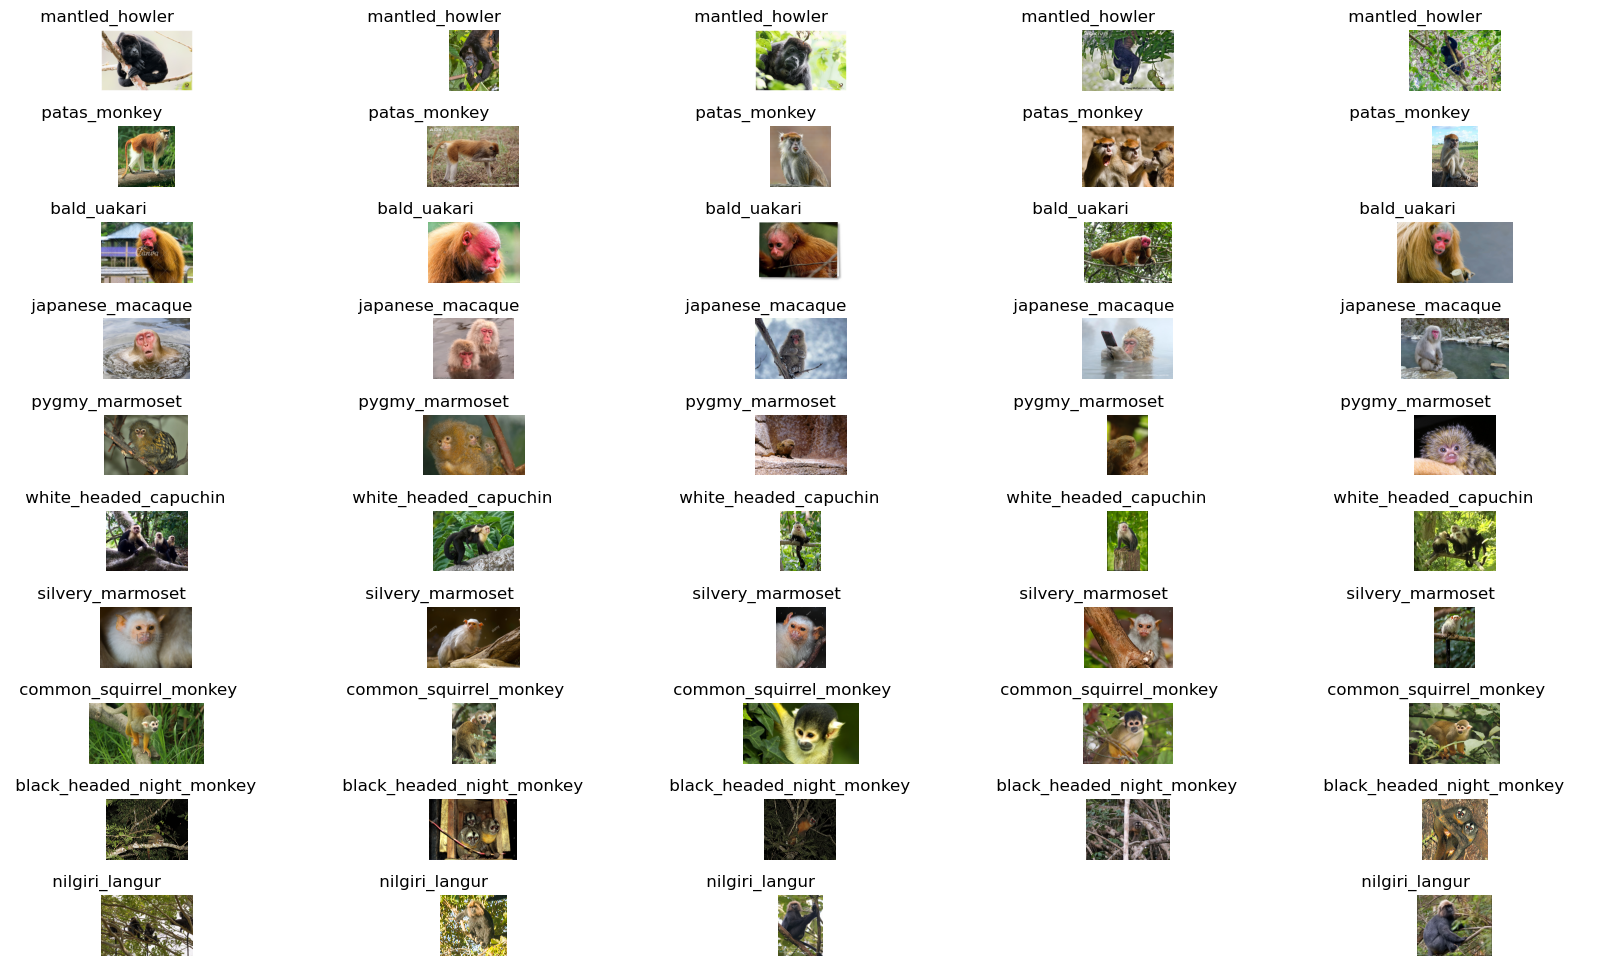

In [11]:
plt.figure(figsize=(18, 10))
c = 1
for n in range(10):
    image_files = os.listdir(f"{train_dir}/n{n}")
    for i in range(5):
        image = plt.imread(f"{train_dir}/n{n}/{image_files[i]}")
        ax = plt.subplot(10, 5, c)
        plt.imshow(image)
        plt.tight_layout()
        plt.title(labels[n])
        plt.axis("off")
        c = c + 1

That looks good enough. The only problem I see is that the images are of different resolutions and even the aspect ratio is different. This can be fixed in the next step.

### Image Processing
It's time to load the images so that we can use them to train the models. I've resized every image to 256x256, so that the CNNs can uniformly do their job.

In [7]:
height = 256
width = 256
batch_size = 64

# Training generator
train_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    shuffle=True,
    class_mode='categorical')

# Test generator
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(height, width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')


Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


Let us also see if the labels are correct. Since the training images have been shuffled and have a lot of data, I'll look at it for the validation images instead.

In [8]:
validation_generator.labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9], dtype=int32)

Looks good.

## Model Training
Now we can finally get to training the models.

### Model 1
The first model is pretty simple. It takes the image as an input, downscales it enough to extract information, flattens the pixels into a single dimensional array, and then passes them to a dense output layer mapped to the 10 different labels.

In [9]:

model1 = keras.Sequential(
    [
        keras.Input(shape=[256, 256, 3]),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.Dense(10, activation="softmax"),
    ]
)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 256)     12544     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 256)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       524416    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 flatten (Flatten)           (None, 131072)            0

In [34]:
model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

Now let us actually train the model. For this I've used some parameters. The maximum number of epochs is 200, but I've also implemented something called EarlyStopping. Whenever the model finds a new best validation accuracy, it saves the weights. If the validation accuracy hasn't improved from that over 15 epochs, it stops the model early and restores the best weights. This is to preserve the best weights in case we overfit the model.

In [35]:
epochs = 200
#checkpoint = ModelCheckpoint('model1.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)

fitted1 = model1.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    epochs=epochs)

Epoch 1/200
18/18 [==============================] - 24s 1s/step - loss: 4.0931 - accuracy: 0.1029 - val_loss: 2.5102 - val_accuracy: 0.1544
Epoch 2/200
18/18 [==============================] - 21s 1s/step - loss: 2.3487 - accuracy: 0.1812 - val_loss: 2.1306 - val_accuracy: 0.3382
Epoch 3/200
18/18 [==============================] - 21s 1s/step - loss: 1.9263 - accuracy: 0.3406 - val_loss: 1.5577 - val_accuracy: 0.4779
Epoch 4/200
18/18 [==============================] - 21s 1s/step - loss: 1.4234 - accuracy: 0.5109 - val_loss: 1.5469 - val_accuracy: 0.4596
Epoch 5/200
18/18 [==============================] - 21s 1s/step - loss: 1.1545 - accuracy: 0.6120 - val_loss: 1.4505 - val_accuracy: 0.5221
Epoch 6/200
18/18 [==============================] - 21s 1s/step - loss: 0.9916 - accuracy: 0.6576 - val_loss: 1.4603 - val_accuracy: 0.5441
Epoch 7/200
18/18 [==============================] - 22s 1s/step - loss: 0.7454 - accuracy: 0.7413 - val_loss: 1.3792 - val_accuracy: 0.6066
Epoch 8/200
1

#### Results and Analysis

Let us look at how the model accuracy changes over every epoch for both the training and validation dataset.

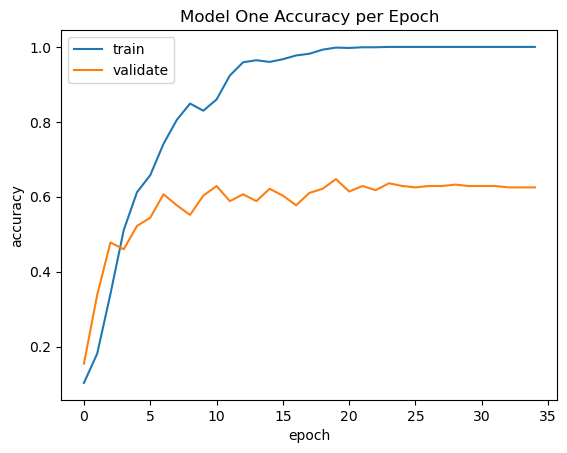

In [36]:
plt.plot(fitted1.history['accuracy'])
plt.plot(fitted1.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

It looks like the validation accuracy increases up to 5 epoch but then the model begins to overfit. Let us actually predict the validation labels so we can do further analysis.

In [52]:
model_predsd = model1.predict(validation_generator)
model_preds = np.argmax(model_predsd, axis=1)
model1_preds

5/5 [==============================] - 4s 826ms/step


array([0, 0, 0, 0, 5, 0, 9, 0, 7, 0, 9, 4, 9, 5, 0, 0, 0, 1, 0, 5, 0, 0,
       0, 9, 0, 0, 3, 1, 1, 4, 8, 9, 1, 7, 1, 0, 5, 8, 1, 1, 4, 1, 1, 1,
       3, 8, 4, 3, 1, 8, 9, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 3, 3, 3,
       3, 4, 0, 4, 4, 4, 4, 3, 5, 4, 4, 4, 6, 4, 6, 4, 4, 4, 4, 4, 4, 7,
       9, 9, 4, 5, 4, 0, 3, 3, 9, 5, 5, 3, 5, 5, 9, 9, 9, 5, 0, 9, 4, 5,
       5, 5, 5, 4, 9, 5, 5, 9, 9, 9, 1, 9, 8, 6, 6, 9, 6, 6, 7, 6, 6, 6,
       8, 6, 6, 3, 8, 6, 6, 6, 6, 5, 6, 6, 3, 6, 6, 7, 4, 7, 9, 1, 7, 7,
       5, 7, 7, 1, 7, 1, 8, 7, 7, 7, 7, 1, 4, 3, 7, 1, 9, 3, 7, 1, 7, 1,
       3, 3, 8, 8, 8, 8, 8, 8, 8, 4, 8, 8, 8, 0, 1, 8, 8, 3, 8, 5, 8, 8,
       8, 5, 3, 8, 9, 0, 9, 9, 9, 7, 9, 9, 0, 9, 0, 9, 9, 0, 0, 0, 3, 9,
       4, 9, 9, 9, 9, 0, 9, 9])

It might be a good idea to generate a confusion matrix since it can give us more information about which labels it accurately predicts.

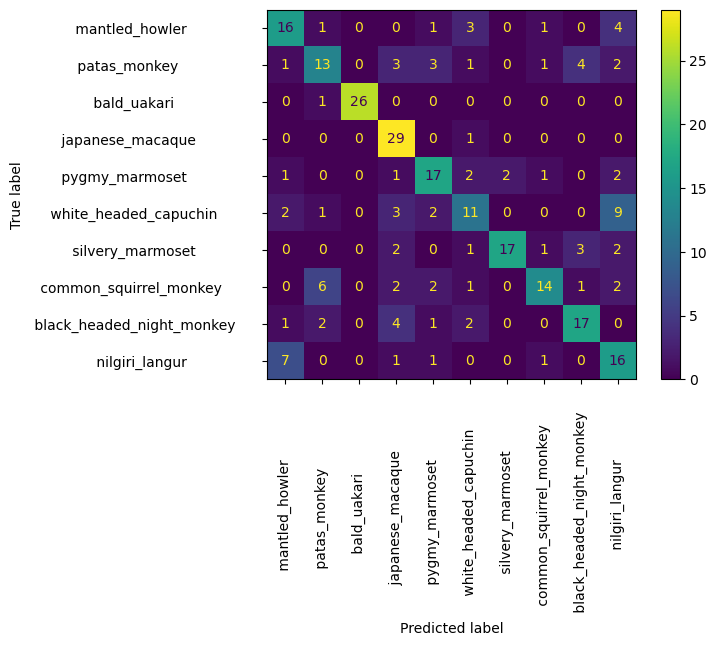

In [60]:
conf_matrix = confusion_matrix(validation_generator.labels, model_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = labels) 
cm_display.plot(xticks_rotation=90)
plt.show()

The model does an okay job but makes quite a few mistakes. The species it confuses the most are white headed capuchin and nilgiri langur.

### Model 2 (Additional Hidden Layer and Slower Learning Rate)

The second model is the same for the convolutional layers. I decided to add another hidden layer after flattening the image, hoping it can extract more information before classifying. I also decided to lower the learning rate, since the quick learning rate could have been a reason it was overfitting as fast as it did.

In [44]:
model2 = keras.Sequential(
    [
        keras.Input(shape=[256, 256, 3]),
        layers.Conv2D(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)


model2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model2.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 256)     12544     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128, 128, 256)     0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 128)       524416    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 flatten_11 (Flatten)        (None, 131072)          

In [45]:
fitted2 = model2.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    epochs=epochs)

Epoch 1/200
18/18 [==============================] - 25s 1s/step - loss: 2.1684 - accuracy: 0.2204 - val_loss: 1.9378 - val_accuracy: 0.3125
Epoch 2/200
18/18 [==============================] - 22s 1s/step - loss: 1.6161 - accuracy: 0.4617 - val_loss: 1.5751 - val_accuracy: 0.4191
Epoch 3/200
18/18 [==============================] - 21s 1s/step - loss: 1.1712 - accuracy: 0.6084 - val_loss: 1.3512 - val_accuracy: 0.5478
Epoch 4/200
18/18 [==============================] - 21s 1s/step - loss: 0.9419 - accuracy: 0.6885 - val_loss: 1.3677 - val_accuracy: 0.5551
Epoch 5/200
18/18 [==============================] - 22s 1s/step - loss: 0.7039 - accuracy: 0.7842 - val_loss: 1.3914 - val_accuracy: 0.5735
Epoch 6/200
18/18 [==============================] - 21s 1s/step - loss: 0.5584 - accuracy: 0.8288 - val_loss: 1.3743 - val_accuracy: 0.5809
Epoch 7/200
18/18 [==============================] - 22s 1s/step - loss: 0.3964 - accuracy: 0.8971 - val_loss: 1.3753 - val_accuracy: 0.5662
Epoch 8/200
1

#### Results and Analysis

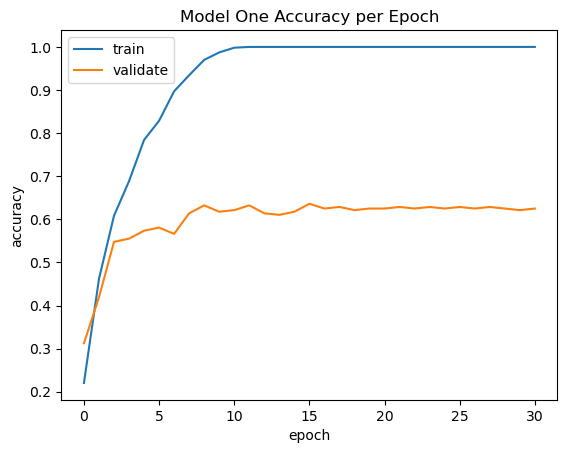

In [46]:
plt.plot(fitted2.history['accuracy'])
plt.plot(fitted2.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

5/5 [==============================] - 4s 822ms/step


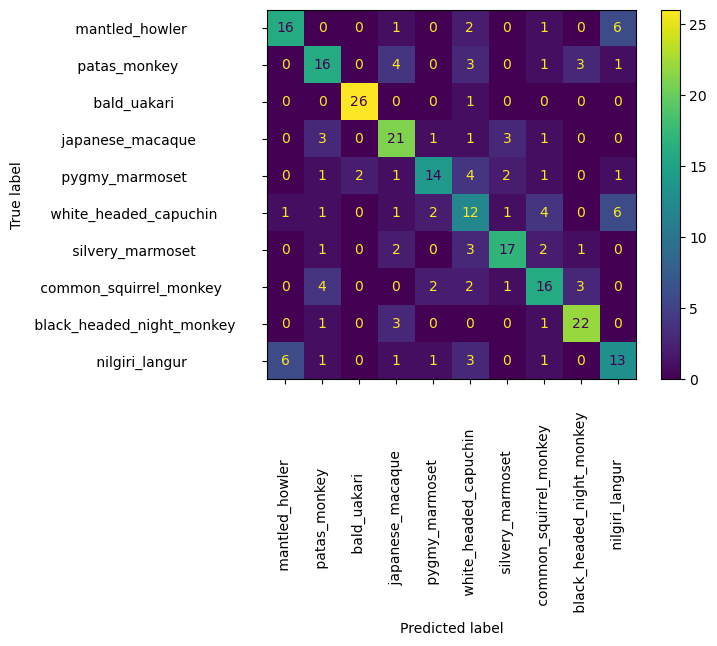

In [47]:
model_predsd = model2.predict(validation_generator)
model_preds = np.argmax(model_predsd, axis=1)
conf_matrix = confusion_matrix(validation_generator.labels, model_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = labels) 
cm_display.plot(xticks_rotation=90)
plt.show()

This model doesn't seem to perform much better than the first one. It doesn't look like adding a hidden layer helped.

### ResNet-50 Model

For the next model I'm going to use transfer learning. The ResNet-50 model is a popular convolutional neural network model. I'm going to use that before flattening the image and classifying it. Let us see how well it performs.

In [32]:

model_resnet = keras.Sequential(
    [
        keras.Input(shape=[256, 256, 3]),
        ResNet50(),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model_resnet.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

model_resnet.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 flatten_5 (Flatten)         (None, 1000)              0         
                                                                 
 dense_7 (Dense)             (None, 512)               512512    
                                                                 
 dense_8 (Dense)             (None, 10)                5130      
                                                                 
Total params: 26,154,354
Trainable params: 26,101,234
Non-trainable params: 53,120
_________________________________________________________________


In [15]:
fitted_resnet = model_resnet.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    epochs=epochs)

Epoch 1/200
18/18 [==============================] - 72s 1s/step - loss: 2.2651 - accuracy: 0.4882 - val_loss: 2.3028 - val_accuracy: 0.1029
Epoch 2/200
18/18 [==============================] - 23s 1s/step - loss: 2.2448 - accuracy: 0.5091 - val_loss: 2.3041 - val_accuracy: 0.0956
Epoch 3/200
18/18 [==============================] - 22s 1s/step - loss: 2.2447 - accuracy: 0.4426 - val_loss: 2.3028 - val_accuracy: 0.1029
Epoch 4/200
18/18 [==============================] - 23s 1s/step - loss: 2.2209 - accuracy: 0.4699 - val_loss: 2.3046 - val_accuracy: 0.0956
Epoch 5/200
18/18 [==============================] - 23s 1s/step - loss: 2.2136 - accuracy: 0.4681 - val_loss: 2.3075 - val_accuracy: 0.0956
Epoch 6/200
18/18 [==============================] - 23s 1s/step - loss: 2.1932 - accuracy: 0.5109 - val_loss: 2.3057 - val_accuracy: 0.0956
Epoch 7/200
18/18 [==============================] - 23s 1s/step - loss: 2.1956 - accuracy: 0.4317 - val_loss: 2.3108 - val_accuracy: 0.1029
Epoch 8/200
1

#### Results and Analysis

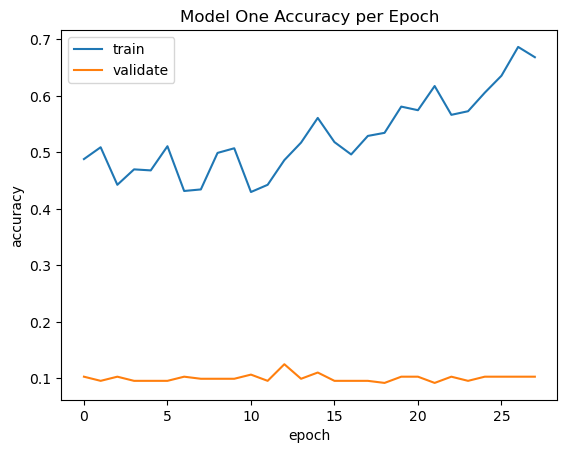

In [16]:
plt.plot(fitted_resnet.history['accuracy'])
plt.plot(fitted_resnet.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

5/5 [==============================] - 5s 715ms/step


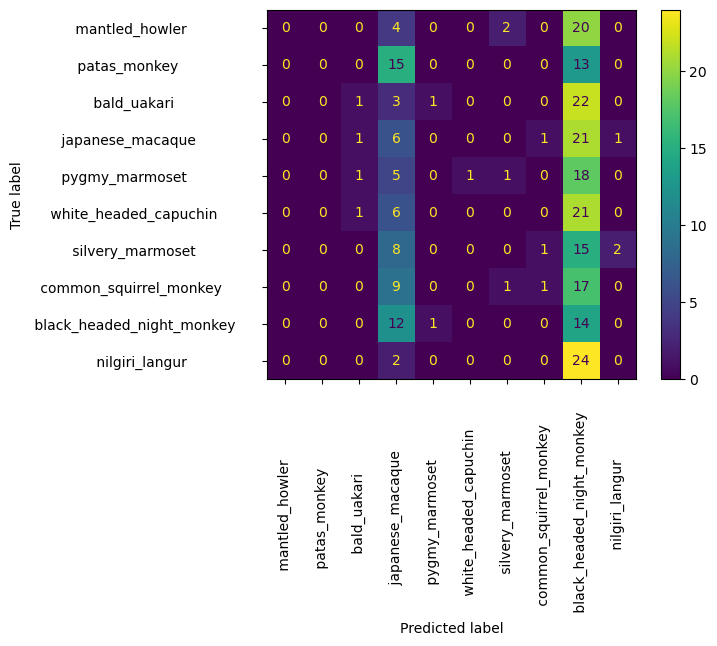

In [17]:
model_predsd = model_resnet.predict(validation_generator)
model_preds = np.argmax(model_predsd, axis=1)
conf_matrix = confusion_matrix(validation_generator.labels, model_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = labels) 
cm_display.plot(xticks_rotation=90)
plt.show()

The ResNet-50 model appears to perform worse than both the previous models. What's also interesting is that it classifies most of the images as belonging to just two species. It is likely that this model performs well only for binary class classification. This could be why I got good performance from this model in week 3's assignment.

### Xception Model
This is another popular CNN model that is commonly used. Let us see how it performs.

In [37]:
model_xception = keras.Sequential(
    [
        keras.Input(shape=[256, 256, 3]),
        Xception(),
        layers.Flatten(),
        layers.Dense(512, activation="relu"),
        layers.Dense(10, activation="softmax"),
    ]
)

model_xception.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
model_xception.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 1000)              22910480  
                                                                 
 flatten_9 (Flatten)         (None, 1000)              0         
                                                                 
 dense_15 (Dense)            (None, 512)               512512    
                                                                 
 dense_16 (Dense)            (None, 10)                5130      
                                                                 
Total params: 23,428,122
Trainable params: 23,373,594
Non-trainable params: 54,528
_________________________________________________________________


In [38]:
fitted_xception = model_xception.fit(train_generator,
                    validation_data=validation_generator,
                    callbacks=[early_stopping],
                    epochs=epochs)

Epoch 1/200
18/18 [==============================] - 62s 1s/step - loss: 2.1574 - accuracy: 0.7213 - val_loss: 2.0214 - val_accuracy: 0.7757
Epoch 2/200
18/18 [==============================] - 24s 1s/step - loss: 1.7520 - accuracy: 0.9299 - val_loss: 1.8638 - val_accuracy: 0.5551
Epoch 3/200
18/18 [==============================] - 24s 1s/step - loss: 1.2298 - accuracy: 0.9226 - val_loss: 2.4138 - val_accuracy: 0.2279
Epoch 4/200
18/18 [==============================] - 25s 1s/step - loss: 0.7563 - accuracy: 0.9117 - val_loss: 1.7980 - val_accuracy: 0.5294
Epoch 5/200
18/18 [==============================] - 24s 1s/step - loss: 0.5003 - accuracy: 0.9098 - val_loss: 2.0822 - val_accuracy: 0.5037
Epoch 6/200
18/18 [==============================] - 24s 1s/step - loss: 0.4105 - accuracy: 0.9244 - val_loss: 3.4990 - val_accuracy: 0.1103
Epoch 7/200
18/18 [==============================] - 25s 1s/step - loss: 0.3758 - accuracy: 0.9217 - val_loss: 4.5394 - val_accuracy: 0.1066
Epoch 8/200
1

#### Results and Analysis

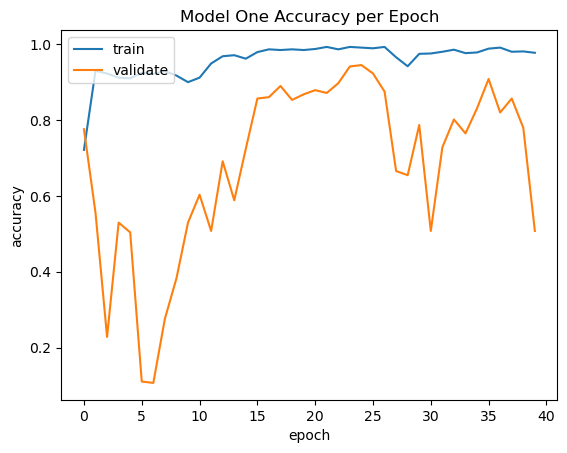

In [39]:
plt.plot(fitted_xception.history['accuracy'])
plt.plot(fitted_xception.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

5/5 [==============================] - 5s 827ms/step


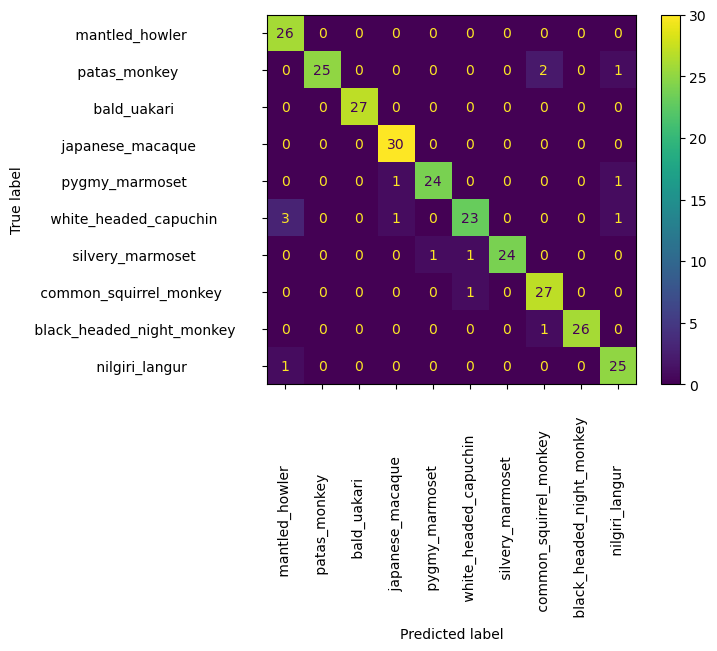

In [41]:
model_predsd = model_xception.predict(validation_generator)
model_preds = np.argmax(model_predsd, axis=1)
conf_matrix = confusion_matrix(validation_generator.labels, model_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = labels) 
cm_display.plot(xticks_rotation=90)
plt.show()

This model seems to perform a lot better, with a validation accuracy of 0.9449. It did appear to overfit at the start, but the validation accuracy picked up pretty fast and it converges quickly into a well-performing model.

## Conclusion/Discusssion
Here is a comparison of the training and accuracy for each model.

| Model | Training | Validation |
| --- | --- | --- |
| Model 1 | 1.0000 | 0.6287 |
| Model 2 | 1.0000 | 0.6360 |
| ResNet-50 | 0.4863 | 0.1250 |
| Xception | 0.9909 | 0.9449 |

Model 1 and 2 have a perfect score on the training data but didn't perform too well on the validation data. ResNet-50 doesn't appear to perform well on either the training or validation data. Xception seems to have the best overall performance, with a nearly perfect score on the training data and an accuracy of 0.9449 on the validation dataset.

One thing this project made me realize is that ResNet-50 only performs well on binary classification and isn't too good for multi-class classification.

This has been a great learning experience for me. One thing to note is that my best model here uses transfer learning. My next step would be to create a model from scratch that can achieve an accuracy score of 0.9 or higher on the validation dataset.

## References
* Mario (2018) 10 monkey species, Kaggle. Available at: https://www.kaggle.com/datasets/slothkong/10-monkey-species (Accessed: 14 August 2023). 